In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 굉장히 많은 라이브러리를 가져오군요

In [ ]:
data_dir = '/content/drive/MyDrive/kaggle-kakr-housing-data'

train_data_path = '/content/drive/MyDrive/kaggle-kakr-housing-data/data/train.csv'
test_data_path = '/content/drive/MyDrive/kaggle-kakr-housing-data/data/test.csv'

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# 마운트해주고!

In [ ]:
train.head() #확인해주고!

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head() #date 길어서 쭐여주고

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
y = train['price']
del train['price']

print(train.columns) 

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


test에 우리가 맞추어야 할 타겟 데이터인 price는 없으니 훈련 데이터셋과는 다르게 price에 대한 처리는 해주지 않아도 된다는 것을 잊지 마세요!

In [ ]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

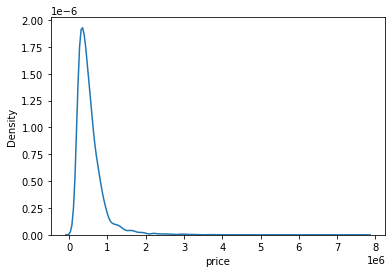

In [ ]:
sns.kdeplot(y)
plt.show()

굉장히 치우쳐 있군요 로그변환을 사용해줍니다


In [ ]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

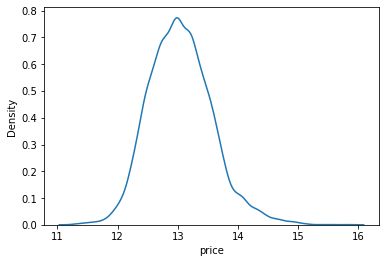

In [ ]:
sns.kdeplot(y)
plt.show()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [ ]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [ ]:
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


In [ ]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [ ]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
df
    

[02:59:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'GradientBoostingRegressor': 128360.19649691365,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562,
 'XGBRegressor': 131067.44622809246}

rmse의 값

In [ ]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y) 

[02:59:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
XGBRegressor,131067.446228
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359


# 다양한 하이퍼 파라미터로 실험

그리드탐색 ~~~~

In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
param_grid = {
    'n_estimators': list(range(0, 201, 5)),
    'max_depth': [1, 10],
}

In [ ]:
model = LGBMRegressor(random_state=random_state)

In [ ]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 82 candidates, totalling 410 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10],
                         'n_estimators': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45,
                                          50, 55, 60, 65, 70, 75, 80, 85, 90,
                                          95, 100, 105, 110, 115, 120, 125, 130,
                                          135, 140, 145, ...]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
grid_model.cv_results_

{'mean_fit_time': array([0.01080699, 0.1621664 , 0.16996636, 0.1758379 , 0.19239454,
        0.21654091, 0.21999192, 0.21283088, 0.2051971 , 0.22922268,
        0.25096788, 0.25930333, 0.27266002, 0.28241792, 0.27686443,
        0.31795425, 0.31878648, 0.32119532, 0.37913246, 0.42890406,
        0.45604815, 0.44931955, 0.50268416, 0.52184134, 0.52864852,
        0.53546958, 0.42823906, 0.43500118, 0.46352353, 0.46445723,
        0.48244739, 0.47781529, 0.49255943, 0.49276676, 0.5115756 ,
        0.51559906, 0.54499664, 0.5360323 , 0.54818268, 0.60325003,
        0.69384184, 0.0121603 , 0.24243612, 0.38993583, 0.46191616,
        0.54536252, 0.64321604, 0.80480728, 0.91969008, 0.91855955,
        1.02640929, 1.18165178, 1.15411539, 1.50439625, 1.60150981,
        1.44615932, 1.85199728, 1.83176346, 1.71945038, 1.83578744,
        2.0301496 , 2.15830379, 2.21157737, 2.18780103, 2.22424288,
        2.01349092, 1.85268369, 1.88786082, 1.98146667, 1.99452   ,
        2.08109131, 2.09004469,

In [ ]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 0},
 {'max_depth': 1, 'n_estimators': 5},
 {'max_depth': 1, 'n_estimators': 10},
 {'max_depth': 1, 'n_estimators': 15},
 {'max_depth': 1, 'n_estimators': 20},
 {'max_depth': 1, 'n_estimators': 25},
 {'max_depth': 1, 'n_estimators': 30},
 {'max_depth': 1, 'n_estimators': 35},
 {'max_depth': 1, 'n_estimators': 40},
 {'max_depth': 1, 'n_estimators': 45},
 {'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 55},
 {'max_depth': 1, 'n_estimators': 60},
 {'max_depth': 1, 'n_estimators': 65},
 {'max_depth': 1, 'n_estimators': 70},
 {'max_depth': 1, 'n_estimators': 75},
 {'max_depth': 1, 'n_estimators': 80},
 {'max_depth': 1, 'n_estimators': 85},
 {'max_depth': 1, 'n_estimators': 90},
 {'max_depth': 1, 'n_estimators': 95},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 1, 'n_estimators': 105},
 {'max_depth': 1, 'n_estimators': 110},
 {'max_depth': 1, 'n_estimators': 115},
 {'max_depth': 1, 'n_estimators': 120},
 {'max_depth': 1, 'n_e

In [ ]:
score = grid_model.cv_results_['mean_test_score']
score

array([        nan, -0.20743709, -0.16308603, -0.13532202, -0.11600544,
       -0.10302959, -0.09359343, -0.08670959, -0.08115327, -0.07686451,
       -0.07339447, -0.07023236, -0.0677478 , -0.06534184, -0.06332736,
       -0.06149896, -0.06000989, -0.0584728 , -0.05716621, -0.05605579,
       -0.05502043, -0.05409911, -0.0532554 , -0.052446  , -0.05180661,
       -0.05113975, -0.05053838, -0.04994104, -0.04935716, -0.04889764,
       -0.04842797, -0.04801056, -0.04760591, -0.04723226, -0.04689121,
       -0.04658619, -0.04627035, -0.04596244, -0.04571827, -0.04546068,
       -0.0451949 ,         nan, -0.13491072, -0.07823406, -0.05420333,
       -0.04287089, -0.03704046, -0.03388092, -0.03198303, -0.03081256,
       -0.02986787, -0.02917734, -0.02873774, -0.02835012, -0.02804793,
       -0.02783415, -0.02766514, -0.0274716 , -0.02734687, -0.02719557,
       -0.02711259, -0.02702714, -0.02695464, -0.02686693, -0.0267664 ,
       -0.02672558, -0.0266837 , -0.02662466, -0.02658144, -0.02

In [ ]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,0,NaN
1,1,5,-0.207437
2,1,10,-0.163086
3,1,15,-0.135322
4,1,20,-0.116005
...,...,...,...
77,10,180,-0.026267
78,10,185,-0.026236
79,10,190,-0.026218
80,10,195,-0.026211


In [ ]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,0,NaN,NaN
1,1,5,-0.207437,0.455453
2,1,10,-0.163086,0.403839
3,1,15,-0.135322,0.367861
4,1,20,-0.116005,0.340596
...,...,...,...,...
77,10,180,-0.026267,0.162072
78,10,185,-0.026236,0.161976
79,10,190,-0.026218,0.161921
80,10,195,-0.026211,0.161897


In [ ]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,0,NaN,NaN
1,1,5,-0.207437,0.455453
2,1,10,-0.163086,0.403839
3,1,15,-0.135322,0.367861
4,1,20,-0.116005,0.340596
...,...,...,...,...
77,10,180,-0.026267,0.162072
78,10,185,-0.026236,0.161976
79,10,190,-0.026218,0.161921
80,10,195,-0.026211,0.161897


In [ ]:
results = results.sort_values('RMSLE')

results

,max_depth,n_estimators,score,RMSLE
81,10,200,-0.026188,0.161828
80,10,195,-0.026211,0.161897
79,10,190,-0.026218,0.161921
78,10,185,-0.026236,0.161976
77,10,180,-0.026267,0.162072
...,...,...,...,...
3,1,15,-0.135322,0.367861
2,1,10,-0.163086,0.403839
1,1,5,-0.207437,0.455453
0,1,0,NaN,NaN


In [ ]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [ ]:
model = LGBMRegressor(max_depth=10, n_estimators=500, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.18772099, 13.09926623, 14.07796788, ..., 13.04568803,
       12.71385717, 13.00232235])

In [ ]:
prediction = np.expm1(prediction)
prediction

array([ 533769.36186567,  488582.77495719, 1300119.98482188, ...,
        463094.24943172,  332320.17427472,  443441.02278276])

In [ ]:
data_dir = '/content/drive/MyDrive/kaggle-kakr-housing-data'

submission_path = '/content/drive/MyDrive/kaggle-kakr-housing-data/data/sample_submission.csv'
submission = pd.read_csv(submission_path)

submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [ ]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.337694e+05
1,15036,4.885828e+05
2,15037,1.300120e+06
3,15038,2.934595e+05
4,15039,3.320000e+05


In [ ]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.1643')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/content/drive/MyDrive/kaggle-kakr-housing-data/submission_lgbm_RMSLE_0.1643.csv


# 회고 

노드를 참고하면 쉽게 되는 코드로써 큰어려움 없이 
잘해낼수 있었습니다 퍼실님의 도움을받아 estimator,depth값을 조절하면 된다는 점을 알게 되었습니다.
